<a href="https://colab.research.google.com/github/pmcwhannel/NBA-analytics/blob/main/ShotChartML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Load data

In [78]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
import timeit as tt
shot_chart_path = '/content/drive/MyDrive/CS631-Project/all_shot_chart_data/part-00*'
# [player key, qtr, make/miss, TOP_dist, LEFT_dist, time remaining, dist shot,
# game score, players_team ,team_1=away, team_2=home, year] + [opponent]
# Names of the variables for indexing.
PK = 0   # Player Key
QTR = 1  # Quarter
SHOT = 2 # make/miss
TD = 3   # distance from top (pixels)
LD = 4   # distance from left (pixels)
TR = 5   # time remaining
DS = 6   # distance of shot from bucket (ft)
GS = 7   # game score after the shot
TM = 8   # This data will be changed from city name to 3-letter abreviation. To match AW and HM value.
AW = 9   # Away team (3-letter abreviation)
HM = 10  # Home team (3-letter abreviation)
YR = 11  # Year (year the seasons ends in)
OPP = 12 # This will be added later

### Setup Spark

In [80]:
%%shell
apt-get update -qq > /dev/null
apt-get install openjdk-8-jdk-headless -qq > /dev/null
wget -q https://downloads.apache.org/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
tar xf spark-2.4.7-bin-hadoop2.7.tgz
pip install -q findspark

In [81]:
%%shell
pip install --upgrade pip
pip install lxml
git clone https://github.com/pmcwhannel/NBA-analytics.git
mv NBA-analytics NBAanalytics # So importing functions is easy

Cloning into 'NBA-analytics'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 47 (delta 20), reused 14 (delta 3), pack-reused 0
Unpacking objects: 100% (47/47), done.


In [82]:
# Have to rename drive to get rid of NBA-analytics -> NBAanalytics
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

import findspark
findspark.init()

from pyspark import SparkContext
sc = SparkContext(appName="YourTest", master="local[*]")

ValueError: ignored

In [ ]:
# Read in shooter data
def find_opp(x):
  '''
  Identify all shots against a single opposing team.
  '''
  if x[TM] == x[AW]: 
    opponent = x[HM] # home team is who shot is against
  else:
    opponent = x[AW] # away team is who shot is against

  return x + [opponent]

def ply_tm_2_abrv(shooter,tm_2_abrv):
  '''
  input ply_tm: the data of the shooter
  input tm_2_abrv: linkage from PLAYER TEAM to 3-letter abreviation(s)
  '''
  if shooter[TM].upper() in tm_2_abrv.keys():
    for abrv in tm_2_abrv[shooter[TM].upper()]: # {'PLAYER TEAM':[abrv,...,]}
      if abrv == shooter[AW]:
        temp = abrv
        return shooter[:TM] + [temp] + shooter[TM+1:]
      elif abrv == shooter[HM]:
        temp = abrv
        return shooter[:TM] + [temp] + shooter[TM+1:]
    # didn't find a 3-letter abrv match
    return shooter[:TM] + ['MISSING'] + shooter[TM+1:] 
  else:
    # didn't find city name
    return shooter[:TM] + ['UNKNOWN'] + shooter[TM+1:]

### Add opponent shooting FG pct (Grid weighting).

In [ ]:
# Team name as pulled from shot chart of shooter
# and mapping to a list of the possible 3-letter abbreviations 
tm_2_abrv ={'ATLANTA':['ATL'],
            'BOSTON':['BOS'],
            'INDIANA':['IND'],
            'CHICAGO':['CHI'],
            'TORONTO':['TOR'],
            'BROOKLYN':['BKN','BRK'],
            'VANCOUVER':['VAN'],
            'NEW YORK':['NYK'],
            'HOUSTON':['HOU'],
            'NEW ORLEANS':['NOP','NOH'],
            'CHARLOTTE':['CHA','CHH','CHO'],
            'DALLAS':['DAL'],
            'GOLDEN STATE':['GSW'],
            'OKLAHOMA CITY':['OKC'],
            'CLEVELAND':['CLE'],
            'LA CLIPPERS':['LAC'],
            'DENVER':['DEN'],
            'DETROIT':['DET'],
            'HOUSTON':['HOU'],
            'LA LAKERS':['LAL'],
            'MINNESOTA':['MIN'],
            'MEMPHIS':['MEM'],
            'MILWAUKEE':['MIL'],
            'MIAMI':['MIA'],
            'ORLANDO':['ORL'],
            'PHILADELPHIA':['PHI'],
            'PORTLAND':['POR'],
            'SACRAMENTO':['SAC'],
            'TORONTO':['TOR'],
            'SAN ANTONIO':['SAS'],
            'UTAH':['UTA'],
            'PHOENIX':['PHX','PHO'],
            'WASHINGTON':['WSH','WSB','WAS'],
            'SEATTLE':['SEA'],
            'NEW ORLEANS/OKLAHOMA CITY':['NOK'],
            'NEW ORLEANS/OKLAHOMA':['NOK'],
            'NEW JERSEY':['NJN']
            }

In [ ]:
start = tt.default_timer()
rdd = sc.textFile(shot_chart_path).map(lambda x: x.split(',')).map(lambda x: ply_tm_2_abrv(x, tm_2_abrv)).map(lambda x: find_opp(x)).filter(lambda x: int(x[LD]) <= 500 and int(x[TD]) <= 472).cache()
print(rdd.count())
print('Time it took {}'.format(tt.default_timer() - start))
# Number of shooters with a city match but not an abbreviation match: 449472 (Problems fixed)
# Number of shooters without a city match at all: 113419 (Problems fixed)

4750345
Time it took 22.292592416999923


In [ ]:
# Get only NOK for working on a subset of data # (13079 shots)
small_rdd = rdd.filter(lambda x: x[OPP] == 'NOK').cache()

In [ ]:
import math
def normpdf(x, mean, sd):
  # Calcualte 1-D gaussian
  var = float(sd)**2
  denom = (2*math.pi*var)**.5
  num = math.exp(-(float(x)-float(mean))**2 / (2*var))
  return num/denom

def calc_distance(shooter, pos):
  # Calculate distance between player and sample shot
  # sqrt((x-x_i)**2 + (y-y_i)**2)
  return ((int(shooter[LD]) - pos[0])**2 + (int(shooter[TD]) - pos[1])**2)**(0.5)

def calc_opp_fg_pct(shooter,x):
  d = calc_distance(shooter,(x[1],x[2]))
  sd = 4   # THIS NEEDS TO BE TUNED MOST LIKELY
  mean = 0 # THIS SHOULD REMAIN ZERO
  weight = normpdf(d,mean,sd)
  return (x[0], weight) # (make/miss, weight)

def create_grid(x, nx, ny):
  # nx: number of partitions to cut x into
  # ny: number of partitions to cut y into

  x_lim = 500 # horizontal pixel limit
  y_lim = 472 # vertical pixel limit
  x_size = 1 + x_lim // nx # number of pixels per x grid
  y_size = 1 + y_lim // ny # number of pixels per y grid
  avg_fg_pct = [] # [(make_total,miss_total,avg_fg),...m]

  for i in range(0,ny):
    avg_fg_pct.append([])
    for j in range(0,nx):
      avg_fg_pct[i].append([0,0,0])


  for shot, x_pos, y_pos in x[1]:
    xid = x_pos // x_size
    yid = y_pos // y_size
    print()
    temp = avg_fg_pct[yid][xid]
    if shot == 'make':
      avg_fg_pct[yid][xid] =  [temp[0] + 1, temp[1], (temp[0] + 1) / (temp[0] + temp[1] + 1)]
    else:
      avg_fg_pct[yid][xid] = [temp[0], temp[1] + 1, temp[0] / (temp[0] + temp[1] + 1)]
  return (x[0], avg_fg_pct)

def add_opp_pct(x, nx, ny):
  # Calculate shooting pct of players from shooter's position
  #(key, ([shooter],[list of shots]))
  # x[0] => shooter
  # x[1] => list of shots
  shooter = x[1][0]
  x_lim = 500 # horizontal pixel limit
  y_lim = 472 # vertical pixel limit
  x_size = 1 + x_lim // nx # number of pixels per x grid
  y_size = 1 + y_lim // ny # number of pixels per y grid

  return shooter + [(x[1][1][int(shooter[TD]) // y_size][int(shooter[LD]) // x_size])[-1]]

In [ ]:
# Create list of shots against a team
start = tt.default_timer()
nx = 37
ny = 36 
# ('NOK2007', (make/miss, x, y))
# Get rid of shots that are
rdd_shot_against_all = rdd.map(lambda x: (x[OPP] + x[YR], [(x[SHOT], int(x[LD]), int(x[TD]))])).reduceByKey(lambda x,y:
                        x+y).map(lambda x: create_grid(x, nx, ny)).cache() # [(key,[avg_fg_pct for each grid])] run time ~ 100 seconds

# Add opposing FG pct to MJ data
final_rdd = rdd.map(lambda x: (x[OPP] + x[YR],(x))).join(rdd_shot_against_all).map(lambda x:add_opp_pct(x, nx, ny)).cache()

print('Size of final rdd: {}'.format(final_rdd.count()))
print('It took {} to create the shooting history'.format(tt.default_timer() - start))

Size of final rdd: 4750345
It took 112.31856945399977 to create the shooting history


#### Save to textFile

In [ ]:
final_rdd.map(lambda x: ','.join([str(itm) for itm in x])).saveAsTextFile('/content/drive/MyDrive/CS631-Project/' + 'all_shot_chart_data_opp_fg_pct_added_3736')


### Add features to RDD

1.   List item
2.   List item



    -join on player average data
    -join on player metadata

#### Load in player metadata


In [540]:
player_meta.take(1)

['abdelal01,Alaa Abdelnaby,Right,6-10,240lb,1968-06-24,Egypt']

In [83]:
player_meta = sc.textFile('/content/drive/MyDrive/CS631-Project/player_stats/part-000*')

In [84]:
def imp_2_metric(x):
  feet, inches = x[2].split('-')
  weight = float(x[3].strip('lb'))
  return [x[0]] + [x[1]] + [30.48*int(feet) + 2.54*int(inches)] + [weight*0.453592] 

# (playerKey, [shooting hand, height (cm), weight (kg)])
player_meta2= player_meta.map(lambda x: x.split(',')).map(lambda x: [x[0], x[2], x[3], x[4]]).filter(lambda x:
                  x[-1] != 'None').map(lambda x: imp_2_metric(x)).map(lambda x: (x[0],x[1:]))

#### Load in player per game stats

In [85]:
player_per = sc.textFile('/content/drive/MyDrive/CS631-Project/per_game_stats/part-000*')

In [192]:
def custom_split(x):
  temp = x.split(',')
  if len(temp) == 31:
    return temp
  else:
    extra_pos = len(temp) - 31 # check for the number of extra positions
    arr = temp[:4]
    combine = []
    for i in range(0, extra_pos+1):
      combine.append(str(temp[4+i]))
    return arr + [';'.join(combine)] + temp[4 + extra_pos + 1:]

def check_4_dup(x,y):
  if x[0] == 'TOT':
    return x
  elif y[0] == 'TOT':
    return y
  else:
    return x
# PlayerKey, Season, Position, 2P%, 3P%, eFG%.
player_per2 = player_per.map(lambda x: custom_split(x)).map(lambda x: (x[-1] + x[0],(x[2], x))).reduceByKey(lambda x,y: 
      check_4_dup(x,y)).map(lambda x: x[1][1]).map(lambda x: [x[-1], x[0], x[4], x[16], x[13], x[17]]).map(lambda x: (x[0] + x[1], x[2:])) # key is now: playerKey+season

In [214]:
player_per2.filter(lambda x: 'gallida012011' == x[0]).collect()

[('gallida012011', ['PF;SF', '0.467', '0.352', '0.495'])]

#### Join meta data to shooter RDD (loading in RDD)

In [200]:
rdd_3736 = sc.textFile('/content/drive/MyDrive/CS631-Project/all_shot_chart_data_opp_fg_pct_added_3736/part-00*')

# rdd: [PlayerKey, qtr, shot, TD, LD, timeRemaining, distance, gamescore, team, away, home, year, opp, opp-fg%]
# player_meta2: [shooting hand, height (cm), weight (kg)]
# player_per: [position, 2P%, 3P%, eFG%]
# 4750345 number of shots
# .filter(lambda x: x[1][1] != None)
rdd_3736_meta_per = rdd_3736.map(lambda x: x.split(',')).map(lambda x: (x[0],x[1:])).join(player_meta2).map(lambda x:
                      [x[0]] + x[1][0] + x[1][1]).map(lambda x: (x[0] + x[11],x[:])).join(player_per2).map(lambda x: x[1][0] + x[1][1]).cache()

#### Save to textFile

In [201]:
rdd_3736_meta_per.map(lambda x: ','.join([str(itm) for itm in x])).saveAsTextFile('/content/drive/MyDrive/CS631-Project/' + 'all_shooter_3736')

### ML + Data vis and analysis

In [508]:
shooter_data = []
for i in range(0,20):
  if i <= 9:
    end_str = str(0) + str(i)
  else:
    end_str = str(i)
  lines = open('/content/drive/MyDrive/CS631-Project/' + 'all_shooter_1211/part-000' + end_str ).readlines()
  
  print('Reading in part-000{}'.format(end_str))
  for line in lines:
    shooter_data.append([feature.strip() for feature in line.split(',')])


Reading in part-00000
Reading in part-00001
Reading in part-00002
Reading in part-00003
Reading in part-00004
Reading in part-00005
Reading in part-00006
Reading in part-00007
Reading in part-00008
Reading in part-00009
Reading in part-00010
Reading in part-00011
Reading in part-00012
Reading in part-00013
Reading in part-00014
Reading in part-00015
Reading in part-00016
Reading in part-00017
Reading in part-00018
Reading in part-00019


In [509]:
import pandas as pd
import random
# Grab last 100,000 shots and make model
recent_shooters = random.sample(shooter_data,50000)
data = pd.DataFrame(recent_shooters, columns = ['PlayerKey','Quarter','FGM','TD','LD','TimeRemaining','Distance','GameScore','Team',
                                        'Away','Home','Season','Opponent','OPPFGPct','Hand','Height','Weight','Position','2P%','3P%','eFG%'])


In [512]:
# convert data to numerical representations for model compatibility
def check_pct_type(x):
  if len(x) == 0:
    return 0.0
  else:
    return float(x)

def net_score(x):
  temp = x.split('-')
  return int(temp[0]) - int(temp[1])

def one_hot_pos(df):
  pos_list = df['Position'].tolist()
  pos_2_idx = {'PG':0,'SG':1,'SF':2,'PF':3,'C':4}
  temp = []
  for pos in pos_list:
    agg = [0,0,0,0,0]
    for p in pos.split(';'):
      agg += np.array([1 if i == pos_2_idx[p] else 0 for i in range(0,5)])
    temp.append(list(agg))
  return np.array(temp)

data['FGM'] = data['FGM'].apply(lambda x: int(x=='make'))
data['Distance'] = data['Distance'].apply(lambda x: int(x))
data['TD'] = data['TD'].apply(lambda x: int(x))
data['LD'] = data['LD'].apply(lambda x: int(x))
data['OPPFGPct'] = data['OPPFGPct'].apply(lambda x: float(x))
data['Quarter'] = data['Quarter'].apply(lambda x: int(x))
data['Hand'] = data['Hand'].apply(lambda x: int(x.lower() == 'right'))
data['2P%'] = data['2P%'].apply(lambda x: check_pct_type(x))
data['3P%'] = data['3P%'].apply(lambda x: check_pct_type(x))
data['eFG%'] = data['eFG%'].apply(lambda x: check_pct_type(x))
data['GameScore'] = data['GameScore'].apply(lambda x: net_score(x))
one_hot_mat = one_hot_pos(data)
data['PG'] = one_hot_mat[:,0]
data['SG'] = one_hot_mat[:,1]
data['SF'] = one_hot_mat[:,2]
data['PF'] = one_hot_mat[:,3]
data['C'] = one_hot_mat[:,4]

#### Data visualizations and analysis

In [396]:
import seaborn as sns
import matplotlib.pyplot as plt

<Figure size 1440x1440 with 0 Axes>

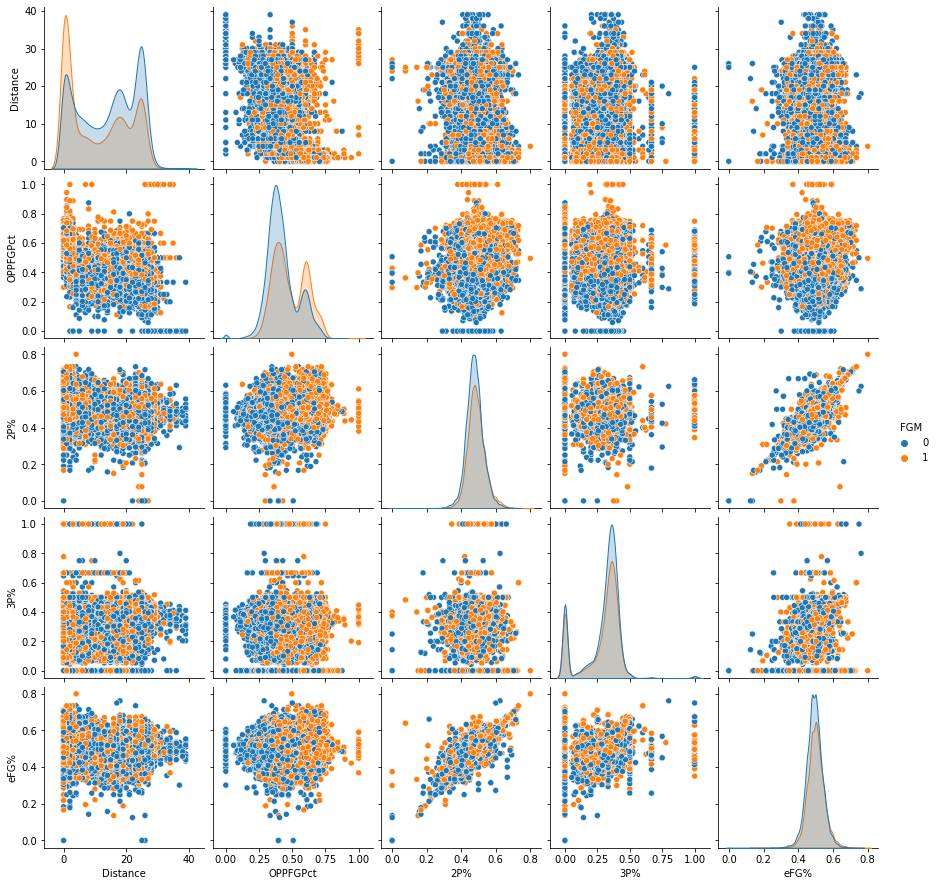

In [536]:
fig = plt.figure(figsize=(20,20))
sns.pairplot(data[['FGM','Distance','OPPFGPct','2P%','3P%','eFG%']], hue='FGM')

#### Building Model

In [513]:
import sklearn
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.linear_model import LogisticRegression as lr
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

In [514]:
def accuracy(preds,targets):
  n = len(preds)
  return sum(preds == targets) / n

In [515]:
data.head()

,PlayerKey,Quarter,FGM,TD,LD,TimeRemaining,Distance,GameScore,Team,Away,Home,Season,Opponent,OPPFGPct,Hand,Height,Weight,Position,2P%,3P%,eFG%,PG,SG,SF,PF,C
0,thompkl01,2,0,77,96,0:27.0,15,-13,GSW,GSW,POR,2019,POR,0.403846,1,198.12,97.52228,SG,0.516,0.402,0.553,0,1,0,0,0
1,denglu01,3,1,53,225,5:59.0,2,-11,CHI,CHI,CLE,2005,CLE,0.595596,1,205.74,107.501304,SF,0.472,0.265,0.458,0,0,1,0,0
2,jamisan01,4,0,103,222,4:41.0,6,-3,CLE,MEM,CLE,2011,MEM,0.344828,1,203.2,101.151016,PF,0.462,0.346,0.479,0,0,0,1,0
3,favorde01,4,1,150,239,3:00.0,12,0,UTA,UTA,HOU,2016,HOU,0.574468,1,205.74,120.20188,PF,0.518,0.000,0.515,0,0,0,1,0
4,tollian01,4,0,247,386,1:16.0,25,-9,MIN,MIN,LAL,2012,LAL,0.377778,1,203.2,108.86207999999999,SF,0.568,0.248,0.459,0,0,1,0,0


In [537]:
X_train, X_test, y_train, y_test = train_test_split(data[['GameScore']], data['FGM'], test_size=0.33, random_state=10)

##### Logistic Regression

In [538]:
# OPPFGPct booster
# GameScore net diff is a booster
clf = lr(random_state=1,penalty='l2', C=1).fit(X=X_train,y=y_train)
preds = clf.predict(X_test)
prop = sum(y_test == np.zeros(len(y_test))) / len(y_test)
print('The larger proportion is {:.2f}% of the dataset'.format(max(prop,1-prop)*100))
print('The accuracy was {:.2f}%'.format(accuracy(preds, np.array(y_test))*100))

The larger proportion is 54.50% of the dataset
The accuracy was 55.17%


##### Random Forest

The larger proportion is 54.50% of the dataset
The accuracy was 55.19%
The larger proportion is 54.50% of the dataset
The accuracy was 55.45%
The larger proportion is 54.50% of the dataset
The accuracy was 55.21%
The larger proportion is 54.50% of the dataset
The accuracy was 56.05%
The larger proportion is 54.50% of the dataset
The accuracy was 55.70%
The larger proportion is 54.50% of the dataset
The accuracy was 55.63%
The larger proportion is 54.50% of the dataset
The accuracy was 55.32%
The larger proportion is 54.50% of the dataset
The accuracy was 55.64%
The larger proportion is 54.50% of the dataset
The accuracy was 55.70%
The larger proportion is 54.50% of the dataset
The accuracy was 55.33%


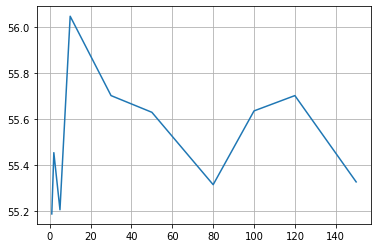

In [539]:
# Boostrapping ..
depth_list = [1,2,5,10,30,50,80,100,120,150]
acc_list = []
for d in depth_list:
  clf = rfc(n_estimators = d, max_depth=5, bootstrap=True, max_samples=0.5).fit(X=X_train,y=y_train)

  # No Bootstrap
  #clf = rfc(n_estimators = 50, max_depth=8).fit(X=X_train,y=y_train)

  preds = clf.predict(X_test)
  prop = sum(y_test == np.zeros(len(y_test))) / len(y_test)
  acc = accuracy(preds, np.array(y_test))*100
  acc_list.append(acc)
  print('The larger proportion is {:.2f}% of the dataset'.format(max(prop,1-prop)*100))
  print('The accuracy was {:.2f}%'.format(acc))

plt.plot(depth_list, acc_list)
plt.grid()

##### SVC (normal) too slow

In [339]:
clf = SVC().fit(X=X_train,y=y_train)
preds = clf.predict(X_test)
prop = sum(y_test == np.zeros(len(y_test))) / len(y_test)
print('The larger proportion is {:.2f}% of the dataset'.format(max(prop,1-prop)*100))
print('The accuracy was {:.2f}%'.format(accuracy(preds, np.array(y_test))*100))

The larger proportion is 54.92% of the dataset
The accuracy was 61.49%


##### SVC - Linear

In [338]:
clf = LinearSVC().fit(X=X_train,y=y_train)
preds = clf.predict(X_test)
prop = sum(y_test == np.zeros(len(y_test))) / len(y_test)
print('The larger proportion is {:.2f}% of the dataset'.format(max(prop,1-prop)*100))
print('The accuracy was {:.2f}%'.format(accuracy(preds, np.array(y_test))*100))

The larger proportion is 54.92% of the dataset
The accuracy was 64.35%


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
